# No More Alzheimer's Disease

## General Data Processing

### Data Downloading

In [3]:
# Imports
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

### Data Pre-Processing

Each necessary file is downloaded, unnecessary fields are removed and labels are assigned.

In [51]:
'''This function reads and does some pre-processing for the data files provided.'''

ugot = pd.read_csv("Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv")
# Read the labels that will be used for both of the files
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


#-------------------------UGOT------------------------------------------------------------------------
# Now merge these two files and remove any rows that have null values
ugot = pd.merge(ugot, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna(subset=['RID', 'PLASMAPTAU181', 'DX'])
# Update Stamp is not relevant for this test
ugot.drop(['update_stamp', 'VISCODE', 'VISCODE2', 'COMMENT', 'VID', 'EXAMDATE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
ugot = ugot.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
ugot.to_csv("Data/ProcessedData/UGOT.csv", index=False)

# -------------------------UPENN----------------------------------------------------------------------
upenn = pd.read_csv("Data/Plasma/UPENNPLASMA_27Nov2023.csv")
upenn = pd.merge(upenn, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
upenn.drop(['update_stamp', 'VISCODE'], axis=1, inplace=True)
# This puts the labels in the same format used for the tests
upenn = upenn.replace("Dementia", "AD").replace("CN", "SCD").reset_index(drop=True)
upenn["AB42/AB40"] = upenn["AB42"] / upenn["AB40"]
upenn.drop(['AB42', 'AB40'], axis=1, inplace=True)

upenn.to_csv("Data/ProcessedData/UPENN.csv", index=False)


# --------------------------ADNI_MERGE-----------------------------------------------------------------
adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")
adni_merge = adni_merge.loc[:, ~adni_merge.columns.str.endswith('_bl')]
adni_merge = adni_merge.loc[:, ['RID', 'VISCODE', 'DX', 'MMSE', 'AGE', 'PTAU', 'TAU', 'ABETA']]
regex_pattern = r'[<>](\d+)'

# This applies to all columns
adni_merge = adni_merge.apply(lambda col: col.astype(str).str.replace(regex_pattern, r'\1', regex=True))
adni_merge = adni_merge.replace('nan', np.nan).dropna()

# Change to required format and save with the viscode for feature selection later
adni_merge = adni_merge.replace("CN", "SCD").replace("Dementia", "AD")
adni_merge.to_csv("Data/ProcessedData/ADNIMerge_WVC.csv")

# Now save without the feature selection
adni_merge.drop('VISCODE', inplace = True, axis = 1)

# --------------------------PLASMA_ABETA_PROJECT--------------------------------------------------------
p_ab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')
# Drop the VISCODE column and replace it with VISCODE2 (REFERENCE :: https://groups.google.com/g/adni-data/c/Dx_Rgge_XB0)
p_ab.drop('VISCODE', inplace=True, axis=1)
p_ab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
p_ab = pd.merge(p_ab, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').dropna()
p_ab = p_ab.loc[:, ['RID', 'VISCODE', 'DX', 'SEQ', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
p_ab = p_ab.replace("CN", "SCD").replace('Dementia', 'AD')
p_ab["AB42/AB40"] = p_ab["ABETA42"] / p_ab["ABETA40"]
p_ab.drop(['ABETA42', 'ABETA40'], axis=1, inplace=True)

p_ab.to_csv('Data/ProcessedData/Plasma_AB.csv', index = False)


C:\Users\danie\AppData\Local\Temp\ipykernel_7432\3560888884.py:5: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
C:\Users\danie\AppData\Local\Temp\ipykernel_7432\3560888884.py:30: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  adni_merge = pd.read_csv("Data/ADNIMERGE_15Jun2023.csv")


In [52]:
## TRY TO MERGE ADNI_MERGE W/ PLASMA_AB
p_ab = pd.read_csv('Data/ProcessedData/Plasma_AB.csv')
am = pd.read_csv('Data/ProcessedData/ADNIMerge_WVC.csv')

# NOW MERGE BASED ON RID AND VISCODE
merged_df = pd.merge(p_ab, am[['RID', 'VISCODE', 'MMSE', 'AGE']], on=['RID', 'VISCODE'],how = 'outer')

merged_df.to_csv('Data/TempViewedFile.csv')

merged_df

,RID,VISCODE,DX,SEQ,NF_LIGHT,GFAP,AB42/AB40,MMSE,AGE
0,31,m120,SCD,2.0,48.7,145.0,0.042781,30.0,77.7
1,138,m120,MCI,9.0,49.3,142.6,0.053571,NaN,NaN
2,150,m120,MCI,16.0,27.8,114.1,0.046900,NaN,NaN
3,214,m120,AD,17.0,28.9,107.1,0.055600,11.0,65.1
4,303,m132,SCD,116.0,36.9,167.4,0.045954,NaN,NaN
...,...,...,...,...,...,...,...,...,...
2441,5290,m24,NaN,NaN,NaN,NaN,NaN,30.0,67.0
2442,5292,bl,NaN,NaN,NaN,NaN,NaN,30.0,74.3
2443,5292,m24,NaN,NaN,NaN,NaN,NaN,29.0,74.3
2444,5295,bl,NaN,NaN,NaN,NaN,NaN,29.0,75.5


In [53]:
# Read each of the files and select the useful fields

blen = pd.read_csv('Data/Plasma/ADNI_BLENNOWPLASMANFL_10_03_18_27Nov2023.csv')[['RID', 'VISCODE2', 'PLASMA_NFL']]
fnih = pd.read_csv('Data/Plasma/FNIH_PLASMA_PTAU181_PROJECT_27Nov2023.csv')[['RID', 'VISCODE2', 'PTAU_181']]
#??????
# fuji = pd.read_csv('Data/Plasma/FUJIREBIOABETAPLASMA_06Dec2023.csv')[['RID', 'VISCODE2', 'PTAU_181']]
#??????
plasmaab = pd.read_csv('Data/Plasma/PLASMA_ABETA_PROJECT_ADX_VUMC_27Nov2023.csv')[['RID', 'VISCODE2', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP']]
ugot = pd.read_csv('Data/Plasma/UGOTPTAU181_06_18_20_27Nov2023.csv')[['RID', 'VISCODE2', 'PLASMAPTAU181']] # RENAME PTAU
dian = pd.read_csv('Data/Plasma/UPENNPLASMA_27Nov2023.csv')[['RID', 'VISCODE', 'AB40', 'AB42']]

# Rename all of the VISCODE2 => VISCODE for merging (REFERENCE :: https://groups.google.com/g/adni-data/c/Dx_Rgge_XB0)
blen.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
fnih.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
plasmaab.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)
ugot.rename(columns={'VISCODE2': 'VISCODE'}, inplace=True)

# Rename PLASMAPTAU181 => PTAU_181 for merging
ugot.rename(columns={'PLASMAPTAU181' : 'PTAU_181'}, inplace=True)

# Attempt to merge
df = pd.merge(blen, fnih, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, plasmaab, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, ugot, on=['RID', 'VISCODE'], how='outer')
df = pd.merge(df, dian, on=['RID', 'VISCODE'], how='outer')

# Now assign a label to each item
labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]
df = pd.merge(df, labels[['RID', 'VISCODE', 'DX']], on=['RID', 'VISCODE'], how='left').replace('CN', 'SCD').replace('Dementia', 'AD')

# Remove any items that couldn't be classified
df = df.dropna(subset=['DX'])

# Make a copy of the file before the VISCODE entry is removed for later reasons
df.to_csv("Data/ProcessedData/ALL_PLASMA_WVC.csv")
df.drop("VISCODE", inplace=True, axis=1)

# Store the data to a .csv for easier analysis
df.to_csv('Data/ProcessedData/ALL_PLASMA_MERGED.csv', index = False)

# Now select the plasma biomarkers required and remove any ones with null fields

df = df[['PTAU_181_x', 'NF_LIGHT', 'ABETA42', 'ABETA40', 'GFAP', 'DX']].dropna()
df.to_csv('Data/ProcessedData/PLASMA_MERGED.csv', index=False)

C:\Users\danie\AppData\Local\Temp\ipykernel_7432\2039741207.py:28: DtypeWarning: Columns (20,105) have mixed types. Specify dtype option on import or set low_memory=False.
  labels = pd.read_csv('Data/ADNIMERGE_15Jun2023.csv')[['RID', 'VISCODE', 'DX']]


### General Functions

In [4]:
def getXy(df):
    '''
    Seperate the label from the feature data.
    
    Args : 
        df (DataFrame) : The data to be seperated
    Returns :
        X (DataFrame) : The feature data.
        y (list) : The labels associated.'''
    
    # Independant
    X = df.drop("DX", axis=1).values
    # Dependant
    y = df["DX"].values

    return X, y

### SVM Approach

Use Cross Validation to find what parameters suit this problem the best

In [7]:
svm = SVC()

df = pd.read_csv("Data/ProcessedData/PreProcessed_Filtered.csv").drop(["VISCODE", "PLASMATAU"], axis=1)

X, y = getXy(df)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# These are the parameters that will be trialled
param_grid = {
    'C' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['linear', 'poly', 'rbf'],
    'degree' : [2, 3, 4],
    'decision_function_shape' : ['ovr', 'ovo']
}

# Runs every possible combination and gets the best
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=3, scoring='accuracy')

grid_search.fit(X_train, y_train)

# Display the best parameters and best accuracy
print("Best Parameters: ", grid_search.best_params_)
print("Best Score: ", grid_search.best_score_)

Best Parameters:  {'C': 0.01, 'decision_function_shape': 'ovr', 'degree': 2, 'kernel': 'linear'}
Best Score:  0.6862745098039217


Text(0, 0.5, 'Accuracy')

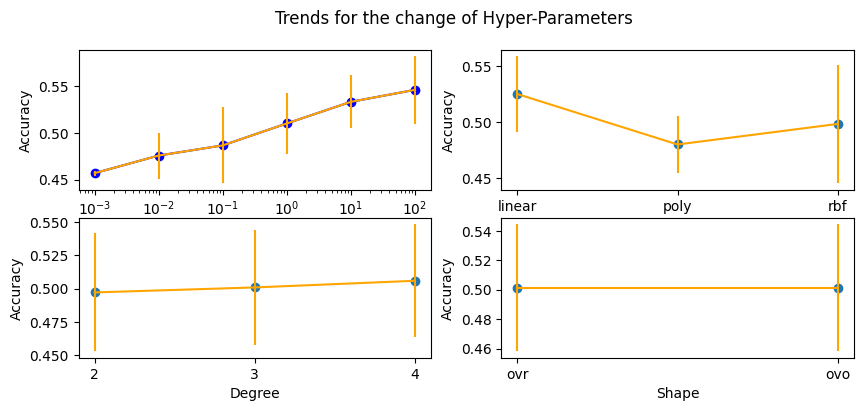

In [ ]:
results = pd.DataFrame(grid_search.cv_results_)

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))
fig.suptitle("Trends for the change of Hyper-Parameters")

c = results.groupby('param_C')['mean_test_score']
plt.subplot(2, 2, 1)
plt.plot(param_grid['C'], c.mean(), color='blue', marker='o')
plt.errorbar(param_grid['C'], c.mean(), yerr=c.std(), color='orange')
plt.xlabel("C value")
plt.ylabel("Accuracy")
plt.xscale('log')

kernel = results.groupby('param_kernel')['mean_test_score']
plt.subplot(2, 2, 2)
plt.scatter(param_grid['kernel'], kernel.mean())
plt.errorbar(param_grid['kernel'], kernel.mean(), yerr=kernel.std(), color='orange')
plt.xlabel("Kernel")
plt.ylabel("Accuracy")

degrees = results.groupby('param_degree')['mean_test_score']
plt.subplot(2, 2, 3)
plt.scatter(['2', '3', '4'], degrees.mean())
plt.errorbar(['2', '3', '4'], degrees.mean(), yerr=degrees.std(), color='orange')
plt.xlabel("Degree")
plt.ylabel("Accuracy")

shape = results.groupby('param_decision_function_shape')['mean_test_score']
plt.subplot(2, 2, 4)
plt.scatter(param_grid['decision_function_shape'], shape.mean())
plt.errorbar(param_grid['decision_function_shape'], shape.mean(), yerr=shape.std(), color='orange')
plt.xlabel("Shape")
plt.ylabel("Accuracy")

# TODO :: Comment and fix the fact that there is no x label for top grpahs
# TODO :: See if the loss function cab be printed

## Test for these hyper-parameters

In [6]:
print("Best Parameters " + str(grid_search.best_params_))

# Creates a SVC object with the best parameters selected.
test_classifier = SVC(
    C = grid_search.best_params_['C'],
    decision_function_shape = grid_search.best_params_['decision_function_shape'],
    degree = grid_search.best_params_['degree'],
    kernel = grid_search.best_params_['kernel']
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)

print("Accuracy is " + str(accuracy_score(y_test, y_testresult)))
print("Recall was " + str(recall_score(y_test, y_testresult, average=None)))

NameError: name 'grid_search' is not defined

### Binary Decision Tree SVM Classifier

# Random Forest Approach

In [1]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
# Create the test object
rf = RandomForestClassifier()

# Re-read the dataframe
df = pd.read_csv("Data/ProcessedData/FilteredData2.csv").drop(["RID", "VISCODE"], axis=1)

X, y = getXy(df)

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we create the grid of params we need to test
param_grid = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'bootstrap' : [True, False],
    'class_weight' : ['balanced', 'balanced_subsample']
}

# Create the test Object and fit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

In [12]:
print(grid_search.best_params_)
grid_search.best_score_

{'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'n_estimators': 300}


0.6853604627327256

Text(0, 0.5, 'Accuracy')

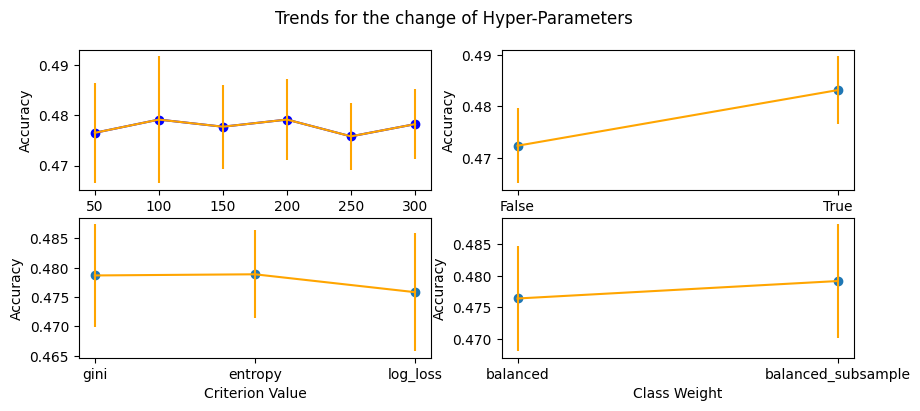

In [7]:
# Plot the results as well as the Standard Dev. of each with the changing parameters

results = pd.DataFrame(grid_search.cv_results_)

fig, axis = plt.subplots(nrows=2, ncols=2, figsize=(10, 4))
fig.suptitle("Trends for the change of Hyper-Parameters")

n = results.groupby('param_n_estimators')['mean_test_score']
plt.subplot(2, 2, 1)
plt.plot(param_grid['n_estimators'], n.mean(), color='blue', marker='o')
plt.errorbar(param_grid['n_estimators'], n.mean(), yerr=n.std(), color='orange')
plt.xlabel("Estimators Amount")
plt.ylabel("Accuracy")

bs = results.groupby('param_bootstrap')['mean_test_score']
plt.subplot(2, 2, 2)
plt.scatter(['False', 'True'], bs.mean())
plt.errorbar(['False', 'True'], bs.mean(), yerr=bs.std(), color='orange')
plt.xlabel("Bootstrapping Value")
plt.ylabel("Accuracy")

c = results.groupby('param_criterion')['mean_test_score']
plt.subplot(2, 2, 3)
plt.scatter(param_grid['criterion'], c.mean())
plt.errorbar(param_grid['criterion'], c.mean(), yerr=c.std(), color='orange')
plt.xlabel("Criterion Value")
plt.ylabel("Accuracy")

cw = results.groupby('param_class_weight')['mean_test_score']
plt.subplot(2, 2, 4)
plt.scatter(param_grid['class_weight'], cw.mean())
plt.errorbar(param_grid['class_weight'], cw.mean(), yerr=cw.std(), color='orange')
plt.xlabel("Class Weight")
plt.ylabel("Accuracy")

In [8]:
print("Best Parameters " + str(grid_search.best_params_))

# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion'],
    random_state = 42 # Ensure reprodcibility
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)

# Print the test results
print("Accuracy is " + str(accuracy_score(y_test, y_testresult)))
# Get the recall and metrics for each class
recall = list(recall_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
precision = list(precision_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
f1 = list(f1_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))

data = [["Recall"] + recall]
data.append(["Precision"] + precision)
data.append(["F1 Score"] + f1)

labels = sorted(set(y_test))  # Gets the order of the labels



table = tabulate(data, ['', 'SCD', 'MCI', 'AD'], tablefmt="grid")
print(table)

# print(confusion_matrix(y_test, y_testresult, labels=['SCD', 'MCI', 'AD']))

# Maybe BC there is the most MCI

Best Parameters {'bootstrap': True, 'class_weight': 'balanced_subsample', 'criterion': 'gini', 'n_estimators': 100}
Accuracy is 0.470873786407767
+-----------+----------+----------+----------+
|           |      SCD |      MCI |       AD |
+===========+==========+==========+==========+
| Recall    | 0.357143 | 0.57732  | 0.410256 |
+-----------+----------+----------+----------+
| Precision | 0.446429 | 0.474576 | 0.5      |
+-----------+----------+----------+----------+
| F1 Score  | 0.396825 | 0.52093  | 0.450704 |
+-----------+----------+----------+----------+


## Handling the minority class of AD

Upon inspection of the data set, AD is a very under-represented group in the dataset.

### Data distribution visualisation

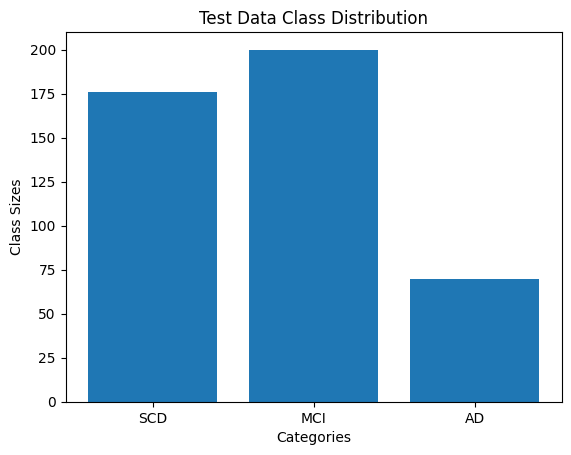

In [9]:
# Read the dataset
df = pd.read_csv("Data/ProcessedData/PLASMA_MERGED.csv")

# Display the size of each of the groups
sizes = [len(df[df["DX"] == "SCD"]), len(df[df["DX"] == "MCI"]), len(df[df["DX"] == "AD"])]

# Represent as a graph
categories = ["SCD", "MCI", "AD"]
plt.bar(categories, sizes)
plt.xlabel('Categories')
plt.ylabel('Class Sizes')
plt.title('Test Data Class Distribution')
plt.show()


### SMOTE Oversampling

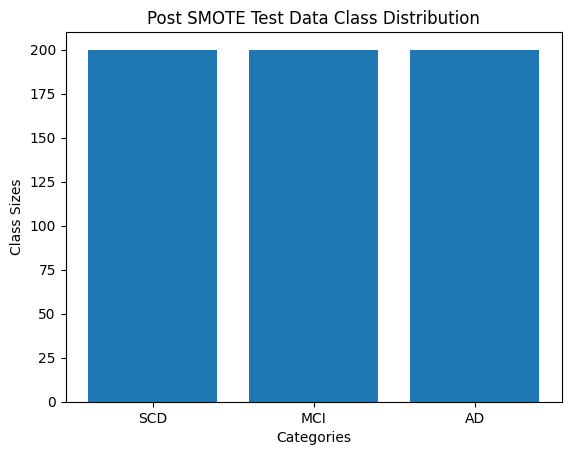

In [ ]:
# Use SMOTE :: SOURCE (https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=8125820)
    # Extra complexity not necessary for this case
# How to implement SMOTE (https://towardsdatascience.com/applying-smote-for-class-imbalance-with-just-a-few-lines-of-code-python-cdf603e58688)

sm = SMOTE(random_state=42)

X, y = getXy(df)

# Oversample the minority classes
X, y = sm.fit_resample(X, y)


# Display the size of each of the groups
sizes = [np.count_nonzero(y == "SCD"), np.count_nonzero(y == "MCI"), np.count_nonzero(y == "AD")]

# Represent as a graph
categoroies = ["SCD", "MCI", "AD"]
plt.bar(categoroies, sizes)
plt.xlabel('Categories')
plt.ylabel('Class Sizes')
plt.title('Post SMOTE Test Data Class Distribution')
plt.show()


## Test Data Model

In [ ]:
# This re-associates the features with the labels
df = pd.DataFrame(data=np.column_stack((X, y)), columns=list(df.drop("DX", axis=1).columns) + ["DX"])

# Get X and y
X, y = getXy(df)

print("Best Parameters " + str(grid_search.best_params_))

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion'],
    random_state = 42, # Ensure reproducibility
)

# Runs a test to find the accuracy of the model
test_classifier.fit(X_train, y_train)

y_testresult = test_classifier.predict(X_test)
# Calculate the training error
y_trainresult = test_classifier.predict(X_train)

# Print the test results
print("\nTesting accuracy is " + str(accuracy_score(y_test, y_testresult)))
print("Training accuracy is " + str(accuracy_score(y_train, y_trainresult)))

# Get the recall and metrics for each class
recall = list(recall_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
precision = list(precision_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))
f1 = list(f1_score(y_test, y_testresult, average=None, labels=['SCD', 'MCI', 'AD']))

print()
# Get all of the data in array forms
data = [["Recall"] + recall]
data.append(["Precision"] + precision)
data.append(["F1 Score"] + f1)

print("TEST ACCURACY")
table = tabulate(data, ['', 'SCD', 'MCI', 'AD'], tablefmt="grid")
print(table)



Best Parameters {'bootstrap': True, 'class_weight': 'balanced', 'criterion': 'gini', 'n_estimators': 100}

Testing accuracy is 0.9916666666666667
Training accuracy is 1.0

TEST ACCURACY
+-----------+----------+----------+------+
|           |      SCD |      MCI |   AD |
+===========+==========+==========+======+
| Recall    | 0.977273 | 1        |    1 |
+-----------+----------+----------+------+
| Precision | 1        | 0.978261 |    1 |
+-----------+----------+----------+------+
| F1 Score  | 0.988506 | 0.989011 |    1 |
+-----------+----------+----------+------+


## Feature Importance

Text(0, 0.5, 'Relative Importance')

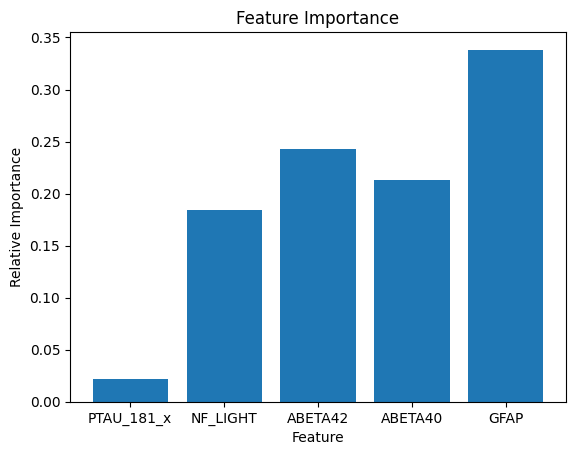

In [ ]:
# Get the importance of each feature in this classifier
importances = test_classifier.feature_importances_

# Now plot these
plt.bar(df.columns[:-1], importances)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")

## Create a master file

In [ ]:
# Read the two files involved

plasma = pd.read_csv("Data/ProcessedData/ALL_PLASMA_MERGED.csv")

# Merge based on VISCODE
plasma

,RID,PLASMA_NFL,PTAU_181_x,NF_LIGHT,ABETA42,ABETA40,GFAP,PTAU_181_y,AB40,AB42,DX
0,2,28.2,NaN,NaN,NaN,NaN,NaN,NaN,153.7,50.9,SCD
1,3,188.3,NaN,NaN,NaN,NaN,NaN,NaN,263.3,58.1,AD
2,4,31.2,NaN,NaN,NaN,NaN,NaN,NaN,192.0,59.8,MCI
3,5,36.3,NaN,NaN,NaN,NaN,NaN,NaN,246.1,46.7,SCD
4,6,52.5,NaN,NaN,NaN,NaN,NaN,NaN,289.0,44.3,MCI
...,...,...,...,...,...,...,...,...,...,...,...
6702,1409,NaN,NaN,NaN,NaN,NaN,NaN,NaN,130.1,33.0,AD
6703,1417,NaN,NaN,NaN,NaN,NaN,NaN,NaN,129.9,40.0,MCI
6704,1423,NaN,NaN,NaN,NaN,NaN,NaN,NaN,143.5,32.4,AD
6705,1426,NaN,NaN,NaN,NaN,NaN,NaN,NaN,153.2,38.4,MCI


## Sparse Data Selection

In [ ]:
# SOURCE :: https://ro.ecu.edu.au/cgi/viewcontent.cgi?article=1654&context=ecuworkspost2013
#           https://www.kaggle.com/code/adizafar/feature-selection-using-genetic-algorithm

# Get the plasma data and merge it with the ADNI data.
plasma = pd.read_csv("Data/ProcessedData/ALL_PLASMA_WVC.csv")
adni = pd.read_csv("Data/ProcessedData/ADNIMerge_WVC.csv")

# Now merge the data together
df = adni.merge(plasma, how = "outer")
# Drop unnamed column
df = df.drop(df.columns[df.columns.str.contains('^Unnamed')], axis=1)

df.to_csv("Data/ProcessedData/FeatureSelectionData.csv", index = False)


In [ ]:
# Read the entire CSV
df = pd.read_csv("Data/ProcessedData/FeatureSelectionData.csv")
df.drop(["VISCODE", "RID"], inplace = True, axis = 1)

df.fillna(0, inplace = True)

# Convert to sparse matrix
X, y = getXy(df)
X = csr_matrix(X)

# Train the random forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)


In [ ]:
# Create the test object
rf = RandomForestClassifier()

# Re-read the dataframe
X, y = getXy(df)

print(X)

# Split for a 20% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Now we create the grid of params we need to test
param_grid = {
    'n_estimators' : [50, 100, 150, 200, 250, 300],
    'criterion' : ['gini', 'entropy', 'log_loss'],
    'bootstrap' : [True, False],
    'class_weight' : ['balanced', 'balanced_subsample']
}

# Create the test Object and fit
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, scoring='accuracy')
grid_search.fit(X_train, y_train)

[[ 20.    81.3   22.83 ...   0.     0.     0.  ]
 [ 17.    81.3   24.18 ...   0.     0.     0.  ]
 [ 27.    67.5   13.29 ...   0.     0.     0.  ]
 ...
 [  0.     0.     0.   ...   0.   143.5   32.4 ]
 [  0.     0.     0.   ...   0.   153.2   38.4 ]
 [  0.     0.     0.   ...   0.   142.9   37.9 ]]


GridSearchCV(cv=3, estimator=RandomForestClassifier(),
             param_grid={'bootstrap': [True, False],
                         'class_weight': ['balanced', 'balanced_subsample'],
                         'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 150, 200, 250, 300]},
             scoring='accuracy')

In [ ]:
print(grid_search.best_params_)
print(grid_search.best_score_)

{'bootstrap': False, 'class_weight': 'balanced_subsample', 'criterion': 'log_loss', 'n_estimators': 200}
0.4811905746176106


In [ ]:
# Test with these hyper-parameters
# Creates a SVC object with the best parameters selected.
test_classifier = RandomForestClassifier(
    bootstrap = grid_search.best_params_['bootstrap'],
    n_estimators = grid_search.best_params_['n_estimators'],
    class_weight = grid_search.best_params_['class_weight'],
    criterion = grid_search.best_params_['criterion'],
    random_state = 42, # Ensure reproducibility
)

# Fit the classifier
test_classifier.fit(X_train, y_train)

# Predict what these classes should be
y_pred = test_classifier.predict(X_test)

# Get the accuracy measures
# Get the recall and metrics for each class
recall = list(recall_score(y_test, y_pred, average = None, labels = ['SCD', 'MCI', 'AD']))
precision = list(precision_score(y_test, y_pred, average = None, labels = ['SCD', 'MCI', 'AD']))
f1 = list(f1_score(y_test, y_pred, average = None, labels = ['SCD', 'MCI', 'AD']))

print()
# Get all of the data in array forms
data = [["Recall"] + recall]
data.append(["Precision"] + precision)
data.append(["F1 Score"] + f1)

# Print the table
print("TEST ACCURACY : " + str(accuracy_score(y_test, y_pred)))
table = tabulate(data, ['', 'SCD', 'MCI', 'AD'], tablefmt = "grid")
print(table)




TEST ACCURACY : 0.474931129476584
+-----------+----------+----------+----------+
|           |      SCD |      MCI |       AD |
+===========+==========+==========+==========+
| Recall    | 0.429253 | 0.532819 | 0.435208 |
+-----------+----------+----------+----------+
| Precision | 0.475352 | 0.502427 | 0.420804 |
+-----------+----------+----------+----------+
| F1 Score  | 0.451128 | 0.517177 | 0.427885 |
+-----------+----------+----------+----------+


Text(0, 0.5, 'Relative Importance')

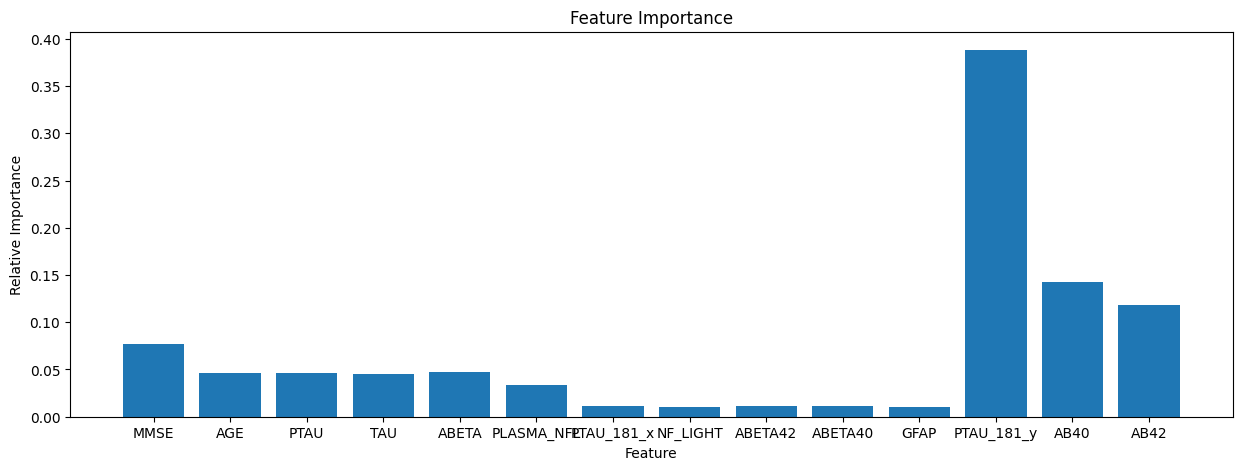

In [ ]:
# Feature importance
# Get the importance of each feature in this classifier
importances = test_classifier.feature_importances_

plt.figure(figsize=(15, 5))

# Now plot these
plt.bar(df.columns[1:], importances)
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Relative Importance")

In [ ]:
# TODO :: Do Feature Selection
# TODO :: Investigate about data sizes affecting graph above
# TODO :: Make sure all patients are seperate